# ænet Tutorial

The materials for this tutorial are available in the following GitHub repository: https://github.com/atomisticnet/psi-k-mlip-workshop-2021

**If you make use of ænet, please cite the following references as appropriate:**

A more in-depth tutorial for the construction of ANN potentials can be found in:

A.M. Miksch, T. Morawietz, J. Kästner, A. Urban, N. Artrith, “Strategies for the Construction of Machine-Learning Potentials for Accurate and Efficient Atomic-Scale Simulations”, [*Mach. Learn.: Sci. Technol.* **2** (2021) 031001](https://doi.org/10.1088/2632-2153/abfd96). 

The atomic energy network (ænet) package: http://ann.atomistic.net

[N. Artrith and A. Urban, *Comput. Mater. Sci.* **114** (2016) 135-150.](http://dx.doi.org/10.1016/j.commatsci.2015.11.047)<br/>
[N. Artrith, A. Urban, and G. Ceder, *Phys. Rev. B* **96** (2017) 014112.](http://dx.doi.org/10.1103/PhysRevB.96.014112)

The ænet-LAMMPS interface:

[M. S. Chen, T. Morawietz, H. Mori, T. E. Markland, and N. Artrith, *J. Chem. Phys.* **155** (2021) 074801.](https://doi.org/10.1063/5.0063880)

The atomic simulation environment (ASE): https://wiki.fysik.dtu.dk/ase/

[A. H. Larsen et al., *J. Phys.: Condens. Matter* **29** (2017) 273002.](https://doi.org/10.1088/1361-648X/aa680e)

The Large-scale Atomic/Molecular Massively Parallel Simulator (LAMMPS): https://www.lammps.org

[A. P. Thompson et al., Comp. Phys. Commun. 271 (2022) 10817.](https://doi.org/10.1016/j.cpc.2021.108171)

Contact: N. Artrith (n.artrith@uu.nl), M. S. Chen (misch@stanford.edu), A. M. Miksch (miksch@theochem.uni-stuttgart.de), A. Urban (a.urban@columbia.edu)

The notebook might have to be restarted to activate the packages that we just installed.  Try to run the following cell.

In [ ]:
try:
  import aenet
  import ase
except ImportError:
  import os
  os.kill(os.getpid(), 9)

We need to import a few Python packages/libraries that will be used below.

In [ ]:
import numpy as np
import pandas as pd
import re
from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 15})
plt.close("all")

## 1. Generating the Reference Data Set (TiO2 bulk)

The first step is the transformation of the atomic structures in the reference data set into a feature-vector representation of local atomic environments.  This is done with the ænet tool `generate.x`. 

We enter a subdirectory in which we will generate the reference data set.

In [ ]:
%cd /work/psi-k-mlip-workshop-2021/01-generate
%ls

/work/psi-k-mlip-workshop-2021/01-generate
generate.in  generate.out  O.fingerprint.stp*  Ti.fingerprint.stp*  TiO2.train


`generate.x` is a command-line tool that reads input parameters from text files. The file `generate.in` is the pricipal input file containing information about the chemical species and the structures in the reference data set:

- The name of the *training set* output file to be generated,
- Atomic energies for each species that are subtracted from the total energy before the potential is trained,
- The file names of the *fingerprint* set-ups for each species that define how the local atomic environment is described, and
- The paths of the atomic structure files in the reference data set.

In [ ]:
! head -n 15 generate.in

OUTPUT TiO2.train

TYPES
2
O   -432.503149303  ! eV
Ti -1604.604515075  ! eV

SETUPS
O   O.fingerprint.stp
Ti Ti.fingerprint.stp

FILES
528
../xsf/structure0161.xsf
../xsf/structure0209.xsf


Let's take a look at the *fingerprint* set-up file for oxygen.  The one for titanium is essentially identical in this example.

- A Chebyshev descriptor [1] with radial expansion order 12 and angular expansion order 5 is used,
- The radial and angular cutoff distances are set to 5 Å and 3 Å, respectively, and
- The minimal distance between atoms is set to be 0.75 Å.

[1] N. Artrith, A. Urban, and G. Ceder, Phys. Rev. B 96 (2017) 014112.

In [ ]:
! cat O.fingerprint.stp

DESCR
  Structural fingerprint setup for O in bulk TiO2.
END DESCR

ATOM O

ENV  2
Ti
O

RMIN 0.75d0

BASIS type=Chebyshev
radial_Rc = 5.0  radial_N = 12  angular_Rc = 3.0  angular_N = 5


In this example, everything is already prepared to start with the reference data set generation.  So, we can simply run `generate.x` and wait until all structures have been processed.  We collect the output that `generate.x` prints to the screen in a file named `generate.out`.  

**Note: this can take a minute**

In [ ]:
! /work/aenet/bin/generate.x-2.0.4-gfortran_serial generate.in > generate.out
print("Reference data set generation completed.")
%ls

 Error: file already exists: TiO2.train
Reference data set generation completed.
generate.in  generate.out  O.fingerprint.stp*  Ti.fingerprint.stp*  TiO2.train


The training-set file `TiO2.train` has been generated. **Note that training-set files are binary files and cannot be opened with a text editor.**

Now, we are ready to train our TiO2 potential.  Let's return to the main directory.

In [ ]:
%cd /work/

/work


## 2. Training an ANN Potential

In this section, we will use the reference data set generated in the previous section to train an artificial neural network (ANN) potential.

Potential training is also done with a command-line tool, which is named `train.x`.  

In [ ]:
%cd /work/psi-k-mlip-workshop-2021/02-train
%ls

/work/psi-k-mlip-workshop-2021/02-train
example-good-ann-fits/  Ti.5t-5t.nn        train.in       train.rngstate
nn.tar.gz               TiO2.train@        train.out
O.5t-5t.nn              TiO2.train.scaled  train.restart


An input file for `train.x`, named `train.in`, has already been prepared for us.  This file contains the following instructions

- The path to the reference data set file (`TiO2.train`),
- The fraction of the data set that should be set aside as validation set,
- The number of training iterations (epochs) to perform,
- The training method and its parameters, and
- The *architecture* of the atomic-energy ANNs for each species.

In [ ]:
%cat train.in

TRAININGSET TiO2.train
TESTPERCENT 10
ITERATIONS  100
MAXENERGY   -0.05 eV

METHOD
bfgs

NETWORKS
! atom   network         hidden
! types  file-name       layers  nodes:activation
  Ti     Ti.5t-5t.nn    2    5:tanh  5:tanh
  O      O.5t-5t.nn     2    5:tanh  5:tanh


Before we can start with training, the reference data set file needs to be made available.  We will create a symbolic link to it in the present directory.

In [ ]:
! ln -s /work/psi-k-mlip-workshop-2021/01-generate/TiO2.train
%ls

ln: failed to create symbolic link './TiO2.train': File exists
example-good-ann-fits/  Ti.5t-5t.nn        train.in       train.rngstate
nn.tar.gz               TiO2.train@        train.out
O.5t-5t.nn              TiO2.train.scaled  train.restart


Now, we perform the training.  Note that this can take a few minutes.  We can observe the training iterations.

In [ ]:
%cd /work/psi-k-mlip-workshop-2021/02-train
! rm -f *.nn train.restart train.rngstate
! /work/aenet/bin/train.x-2.0.4-gfortran_serial train.in | tee train.out
!! tar cfvz nn.tar.gz *.nn-* && rm -f *.nn-*
%ls

/work/psi-k-mlip-workshop-2021/02-train
                       Training process started.                       
                                                                       
                          2021-11-14  18:27:38                         
                                                                       

 Copyright (C) 2015-2018 Nongnuch Artrith and Alexander Urban

 This program is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 Mozilla Public License, v. 2.0, for more details.

 Loading scaled training set file: TiO2.train.scaled

 ----------------------------------------------------------------------
                                Networks                               
 ----------------------------------------------------------------------

 Creating a new O network

 Number of layers :   4

 Number of nodes (without bias) 
 and act

Once training has completed, the ANN potentials for oxygen and titanium are available in `O.5t-5t.nn` and `Ti.5t-5t.nn`.  **Note that ANN potential files are binary and cannot be open in a text editor.** 

In [ ]:
%cd /work/

/work


## 3. Inspecting the Training Results

Was the training successful?  One measure is the performance of the trained potential on the validation set, which is reported for each training epoch on lines that like the following:


    N  MAE_train  RMSE_train  MAE_val  RMSE_val  <
 

`N` is the training iteration (or *epoch*), `MAE_train` and `RMSE_train` are the *mean absolute error* and *root mean squared error* on the training set, and `MAE_val` and `RMSE_val` are the same for the validation set.

Plotting the RMSE of both training and validation set together can be helpful to detect overfitting:

Text(0, 0.5, 'RMSE (eV/atom)')

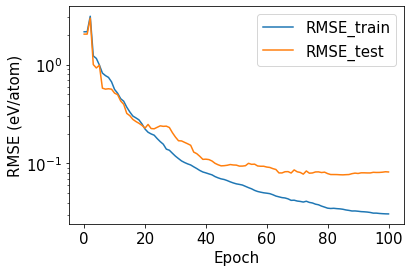

In [ ]:
errors = []
with open("/work/psi-k-mlip-workshop-2021/02-train/train.out") as fp:
  for line in fp:
    if re.match("^ *[0-9].*<$", line):
      errors.append([float(a) for a in line.split()[1:-1]])
errors = np.array(errors)
errors = pd.DataFrame(
    data=errors, 
    columns=['MAE_train', 'RMSE_train', 'MAE_test', 'RMSE_test'])
ax = errors[['RMSE_train', 'RMSE_test']].plot(logy=True)
ax.set_xlabel("Epoch"); ax.set_ylabel("RMSE (eV/atom)")

As seen in the figure, the training-set RMSE continues to decreas long after the test-set RMSE has flattened.  This behavior indicates that the model is overfitting.

Our example uses a very small data set of only ~500 structures, so it is not surprising that overfitting occurs after a few training iterations.

For comparison, we also prepared a training example for a more complex ANN potential that was trained on the complete TiO$_2$ data set containing ~7,000 data points.

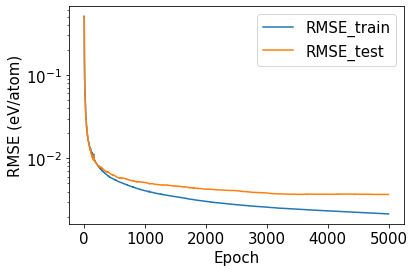

In [ ]:
errors = []
with open("/work/psi-k-mlip-workshop-2021/02-train/example-good-ann-fits/set001/fit-01.dat") as fp:
  for line in fp:
    if re.match("^ *[0-9].*<$", line):
      errors.append([float(a) for a in line.split()[1:-1]])
errors = np.array(errors)
errors = pd.DataFrame(
    data=errors, 
    columns=['MAE_train', 'RMSE_train', 'MAE_test', 'RMSE_test'])
ax = errors[['RMSE_train', 'RMSE_test']].plot(logy=True)
ax.set_xlabel("Epoch"); ax.set_ylabel("RMSE (eV/atom)")
plt.show()

`train.x` can export the errors for all training samples in the training and validation sets.  Here, we visualize the results for one example (set003).

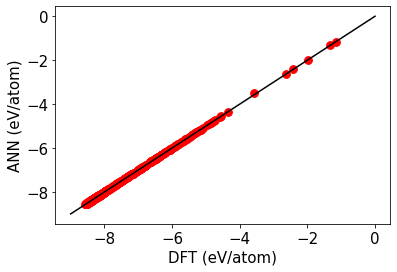

In [ ]:
test = "/work/psi-k-mlip-workshop-2021/02-train/example-good-ann-fits/set003/energies.test.0"
test_errors = np.loadtxt(test, skiprows=1, usecols=(3,4))
plt.plot(np.linspace(-9, 0), np.linspace(-9, 0), color="black")
plt.scatter(test_errors[:,0], test_errors[:,1], color="red", s=60, label="validation")
plt.xlabel('DFT (eV/atom)')
plt.ylabel('ANN (eV/atom)')
plt.show()

## 4. The ænet-Python Interface

Trained ænet ANN potentials can be used with a number of standard simulations packages.  Here we will take a look at the ænet Python interface, which enables compatibility with the Atomic Simulation Environment (ase, see above).

In [28]:
import aenet

try:
    from aenet.ase_calculator import ANNCalculator
except ModuleNotFoundError:
    ! pip install cython
    ! cd /work/aenet/python3 && python3 setup.py build_ext --inplace
    ! cd /work/aenet/python3 && pip install -e . --user
    print("Please restart this notebook.")
    import os
    os.kill(os.getpid(), 9)

import ase
import ase.spacegroup
import ase.visualize
import numpy as np
import pandas as pd
import re
from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 15})
plt.close("all")

We create a new directory and copy the trained potentials into it.

In [29]:
%cd /work/psi-k-mlip-workshop-2021/04-aenetLib-ann-md
%ls

/work/psi-k-mlip-workshop-2021/04-aenetLib-ann-md
fit-01.dat               O.40t-40t.nn*   rutile-eos.traj  rutile.traj
fit-01-get-energies.dat  rutile-eos.png  rutile.png       Ti.40t-40t.nn*


Next, we create an ase structure object with the TiO2 rutile structure. We could have also read this structure from an input file.


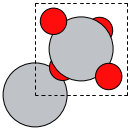

In [30]:
a = 4.6
c = 2.95
atoms = ase.spacegroup.crystal(
    ['Ti', 'O'], basis=[(0, 0, 0), (0.3, 0.3, 0.0)],
    spacegroup=136, cellpar=[a, a, c, 90, 90, 90])
ase.io.write('rutile.traj', atoms)
ase.io.write('rutile.png', atoms)
Image("rutile.png")
#ase.visualize.view(atoms, viewer='x3d')

The ænet Python package provides an ASE *Calculator* class that can load ænet ANN potentials.  In this case, we use the ANN potential from: 

`02-train > example-good-ann-fits > set003`

In [31]:
pot = {"Ti": "/work/psi-k-mlip-workshop-2021/02-train/example-good-ann-fits/set003/Ti.40t-40t.nn", 
       "O": "/work/psi-k-mlip-workshop-2021/02-train/example-good-ann-fits/set003/O.40t-40t.nn"}

# delete old calculator if any is present
if calc and hasattr(calc, 'ann'):
    del calc.ann

calc = ANNCalculator(pot)

This calculator can then be used to predict energies (and atomic forces) for a given atomic structure.

In [32]:
atoms.set_calculator(calc)
E = atoms.get_potential_energy()
print("Total energy = {} eV".format(E))

Total energy = -4990.38881622236 eV


In [33]:
%cd /work

/work


## 5. Python/ASE Example: Equation of States

In this example, we use the `ANNCalculator` and ASE to compute the equation of states of rutile TiO$_2$.

In [34]:
%cd /work/psi-k-mlip-workshop-2021/04-aenetLib-ann-md

/work/psi-k-mlip-workshop-2021/04-aenetLib-ann-md


First, we sample the potential energy around for unit cells with slightly smaller and slightly larger lattice parameters.

In [39]:
from ase.io.trajectory import Trajectory

# delete old calculator if any is present
if calc and hasattr(calc, 'ann'):
    del calc.ann

pot = {"Ti": "/work/psi-k-mlip-workshop-2021/02-train/example-good-ann-fits/set003/Ti.40t-40t.nn", 
        "O": "/work/psi-k-mlip-workshop-2021/02-train/example-good-ann-fits/set003/O.40t-40t.nn"}
calc = ANNCalculator(pot)
eos_atoms = atoms.copy()
eos_atoms.set_calculator(calc)
cell = eos_atoms.get_cell()
traj = Trajectory('rutile-eos.traj', 'w')
for x in np.linspace(0.98, 1.04, 8):
    eos_atoms.set_cell(cell * x, scale_atoms=True)
    eos_atoms.get_potential_energy()
    traj.write(eos_atoms)

This has produced the *trajectory* file `rutile-eos.traj`.

Next, we read the trajectory file and fit an analytical equation of states to the data points.

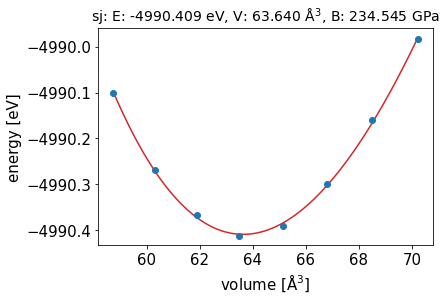

In [36]:
from ase.units import kJ
from ase.eos import EquationOfState
configs = ase.io.read('rutile-eos.traj@0:')  # read 5 configurations
volumes = [c.get_volume() for c in configs]
energies = [c.get_potential_energy() for c in configs]
eos = EquationOfState(volumes, energies)
v0, e0, B = eos.fit()
plt.rcParams.update({"font.size": 15})
plt.rcParams.update({"axes.titlesize": 14})
ax = eos.plot('rutile-eos.png')
ax.ticklabel_format(useOffset=False)
plt.show()

The bulk modulus as predicted by density functional theory (the reference method for our ANN potential) is 235 GPa.

In [ ]:
%cd /work/

/work


## 6. MD Simulations with the ænet-LAMMPS Interface

**Example usage of the ænet-LAMMPS interface for molecular dynamics simulations with artificial neural network (ANN) potentials.**

If you make use of the aenet-LAMMPS interface, please cite the following reference:

M.S. Chen, T. Morawietz, H. Mori, T.E. Markland, N. Artrith, AENET-LAMMPS and AENET-TINKER: Interfaces for Accurate and Efficient Molecular Dynamics Simulations with Machine Learning Potentials, J. Chem. Phys. **155**, 074801 (2021). doi: https://doi.org/10.1063/5.0063880

Preprint (Preprint where the data is discussed)
arXiv (2021) doi: https://arxiv.org/abs/2107.11311

The database can be obtained from the Materials Cloud repository, DOI: https://doi.org/10.24435/materialscloud:dx-ct

Tutorial: https://github.com/atomisticnet/aenet-lammps/tutorial

### Simulation of liquid water (H2O)

An example LAMMPS molecular dynamics simulation of liquid water with an ænet ANN potential is provided as part of the ænet-LAMMPS package.

First we need to make sure that the ænet library file can be dynamically linked when we run LAMMPS.

In [ ]:
%env LD_LIBRARY_PATH=/work/lammps-4Feb20/lib/aenet/lib
!echo $LD_LIBRARY_PATH

env: LD_LIBRARY_PATH=/work/lammps-4Feb20/lib/aenet/lib
/work/lammps-4Feb20/lib/aenet/lib


Below, we run a short example simulation. The parameters of the simulation are specified in the LAMMPS input file `md.lmp`

In [ ]:
%cd /work/psi-k-mlip-workshop-2021/05-aenet-lammps-water
!cat md.lmp

/work/psi-k-mlip-workshop-2021/05-aenet-lammps-water
###############################################################################
# MD simulation for H2O with NN potential
###############################################################################

###############################################################################
# VARIABLES
###############################################################################
clear
variable dt              equal  0.0005                                                  # timestep (0.5fs)
variable intThermo       equal  4                                                       # screen output interval (timesteps)
variable intRestart      equal  4                                                       # restart file interval (timesteps)
variable mass1           equal  1.007825                                                # mass for element 1 (H)  (amu)
variable mass2           equal  15.994915                                               # 

In brief, the conditions of the simulation are:

* NVT simulation of liquid water at 300K
* Initial frame specified by 01_Start/firstframe.start file (64 water molecules in box with side lengths of 12.417 Angstroms)
* H.ann and O.ann are the ænet ANN potential files
* Simulation runs for 100 steps with 0.5 fs spacing between steps and writing out properties every 2.0fs
* Input file flags the use of the "<a href="https://docs.lammps.org/units.html">metal</a>" unit system since the ANN potential was trained using eV units for energies and Angstroms units for positions.
* Positions, velocities, forces, and energies are written out to files in the 02_Traj folder (traj.xyz, velocities.xyz, forces.xyz, and analysis_frames.dat respectively)

Note that the file names of the ænet potentials are specified on the line

    pair_style aenet H.ann O.ann 


The actual simulations is run in the following cell.

In [ ]:
!/work/lammps-4Feb20/src/lmp_mpi -in md.lmp

LAMMPS (4 Feb 2020)
Reading data file ...
  orthogonal box = (0 0 0) to (12.4171 12.4171 12.4171)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  192 atoms
  read_data CPU = 0.00317976 secs
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 8.35
  ghost atom cutoff = 8.35
  binsize = 4.175, bins = 3 3 3
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair aenet, perpetual
      attributes: full, newton on
      pair build: full/bin/atomonly
      stencil: full/bin/3d
      bin: standard
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 0
  Time step     : 0.0005
Per MPI rank memory allocation (min/avg/max) = 6.705 | 6.705 | 6.705 Mbytes
Step Temp E_pair E_mol TotEng Press 
       0          300   -30056.194            0   -30048.787   -4138.7878 
       4    311.16524   -30056.471            0   -30048.789   -2680.0645 
       8    325.61646   -30056

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bfabd374-f7a6-40fd-b4f0-3c25f442361e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>